<a href="https://colab.research.google.com/github/mwbest/CofI_2024/blob/master/asta_H17_47_Radial_Velocity_Calculations_(includes_continuum_and_Voigt_fittings).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Cloning pykosmos from Jim Davenport's GitHub page and installing necessary packages.
# Cloning functions that are additions and modifications to Jim Davenport's and CCD Data Reduction Guide's functions,
# written by The College of Idaho undergraduate students Julene Elias, Abdullah Korra, and Anna Panova
# under the mentorship of professor Dr. Katie Devine.
!git clone https://github.com/jradavenport/pykosmos.git
!git clone https://github.com/mwbest/cofi-kosmos-pipe-funcs.git
!pip install specutils
!pip install ccdproc

Cloning into 'pykosmos'...
remote: Enumerating objects: 1038, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 1038 (delta 116), reused 157 (delta 68), pack-reused 826
Receiving objects: 100% (1038/1038), 33.07 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Cloning into 'cofi-kosmos-pipe-funcs'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 527 (delta 216), reused 394 (delta 161), pack-reused 0
Receiving objects: 100% (527/527), 1.57 MiB | 4.12 MiB/s, done.
Resolving deltas: 100% (216/216), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.5/967.5 

In [14]:
!pip install specreduce

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.8/352.8 kB 5.7 MB/s eta 0:00:00


In [17]:
# Making all necessary imports.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ccdproc import CCDData
from ccdproc import Combiner, trim_image
from ccdproc import cosmicray_lacosmic
from specutils import Spectrum1D
from specutils import analysis
from specutils.fitting import fit_generic_continuum
import warnings
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy.io import fits
import sys
sys.path.append("/content/pykosmos")
sys.path.append("/content/cofi-kosmos-pipe-funcs")
import CofI_KOSMOS as pipe
import pykosmos

In [3]:
# Mounting Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading a spectrum - Spectrum1D object

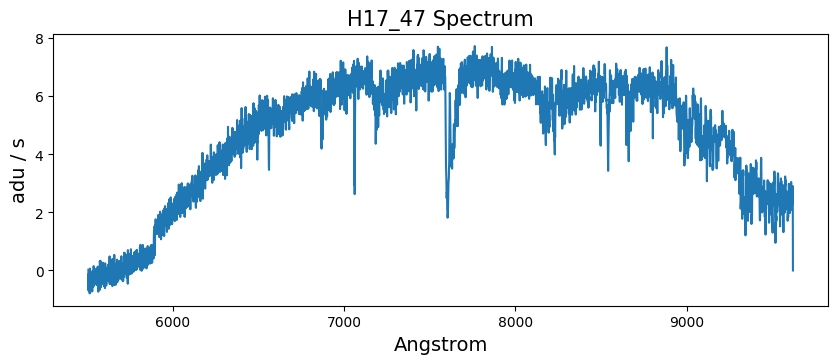

In [4]:
# Reading and plotting a spectrum.
spectrum = '/content/drive/MyDrive/RAISE Student Research/Group Resources/APO24/H17_47.0037 Spectrum'
to_plot = Spectrum1D.read(spectrum, format = "tabular-fits", column_mapping={'flux': ('flux', 'adu/s'), 'wavelength': ('spectral_axis', 'AA'), 'uncertainty': ('uncertainty', 'adu/s')})
plt.figure(figsize = (10,4))
plt.plot(to_plot.spectral_axis, to_plot.flux)
plt.title("H17_47 Spectrum", fontsize = 15)
plt.xlabel(to_plot.spectral_axis.unit, fontsize = 14)
plt.ylabel(to_plot.flux.unit, fontsize = 14)
plt.subplots_adjust(bottom = 0.2)
plt.show()

# Continuum fitting around CaT lines

In [23]:
# FInding the location of  CaT. Usually it can be found between 8450 and 8700 wavelengths.
pixvals = []
for ang in [8450, 8700]:
  wavpos = np.searchsorted(-1 * to_plot.spectral_axis.value, -1 * ang)
  pixvals.append(wavpos+1)
pixvals.sort()
print(pixvals)

[879, 1115]


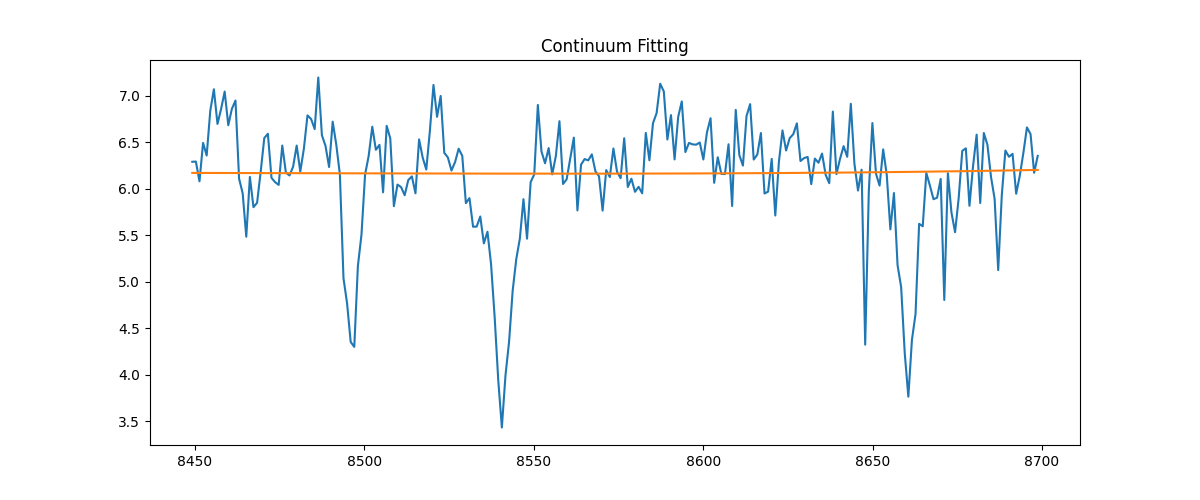

Text(0.5, 1.0, 'After flattening and subtraction to 0')

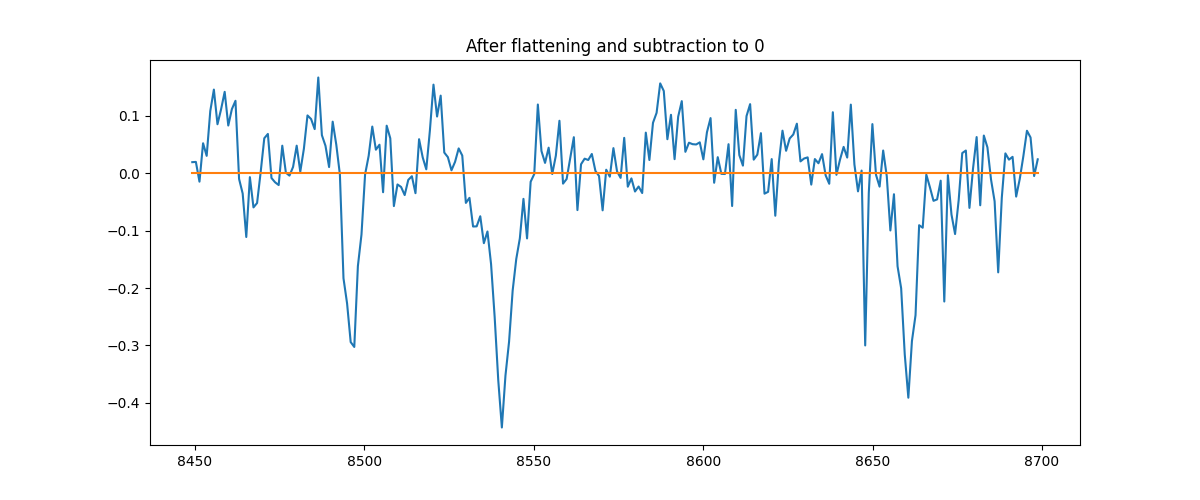

In [24]:
# Attempting to continuum fit around the CaT lines.
x_calc_comb = to_plot.spectral_axis.value[pixvals[0]:pixvals[1]] # This slice should just be a bit bigger than the slice
# found in the code cell above. It doesn't have to be exact, just large enough to see all 3 CaT
# plus a little on both sides.
y_calc_comb = to_plot.flux.value[pixvals[0]:pixvals[1]]
with warnings.catch_warnings():  # Ignore warnings.
    warnings.simplefilter('ignore')
    gcalc_fit_comb = fit_generic_continuum(to_plot[(pixvals[0]-100):(pixvals[1]+100)]) # This slice should be bigger than the slice above.
# Keep changing it until the continuum fit is even and is/close to being a horizontal line.
cont_fit_calcium_comb = gcalc_fit_comb(x_calc_comb * u.angstrom)
# Plot the CaT lines with continuum fit before and after sunbtraction to 0.
plt.figure(figsize = (12,5))
plt.plot(x_calc_comb, y_calc_comb)
plt.plot(x_calc_comb, cont_fit_calcium_comb)
plt.title("Continuum Fitting")
plt.show()
plt.figure(figsize = (12,5))
plt.plot(x_calc_comb, y_calc_comb/cont_fit_calcium_comb.value-1)
plt.plot(x_calc_comb, np.zeros_like(x_calc_comb))
plt.title("After flattening and subtraction to 0")

In [25]:
# Creating a Spectrum1D object for the flattened and subtracted spectrum.
nflux_comb = (y_calc_comb / cont_fit_calcium_comb.value - 1) * u.adu / u.second
nspec_comb = to_plot.spectral_axis[pixvals[0]:pixvals[1]]
unc_comb = to_plot.uncertainty[pixvals[0]:pixvals[1]]
calcium_spec_comb = Spectrum1D(spectral_axis = nspec_comb, flux = nflux_comb, uncertainty = unc_comb)

# Voigt curve fitting

In [8]:
# Use this code to enable interaction with the widget:
!pip install ipympl
!pip install ipywidgets
!pip install matplotlib
!pip install mpl-interactions
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.7 MB/s eta 0:00:00



    Instructions:
    ------------
    0) This assumes the continuum of your spectra is flattened and at 0. For proper interactive widgets, ensure you're
    using the Notebook backend in the Jupyter notebook, e.g.:
#         %matplotlib notebook,
    or in Google Colab:
#         %matplotlib widget
    1) Click the plot at one endpoint, and click the button when you're satisfied.
    2) Click the plot at the other endpoint and click the button again once you have it where you would like.
    3) Click the plot at the vertical extrema (peak or trough) then click the button.
    4) If all your values look right (they will show up on the plot), click the final button to graph your fitted curve.


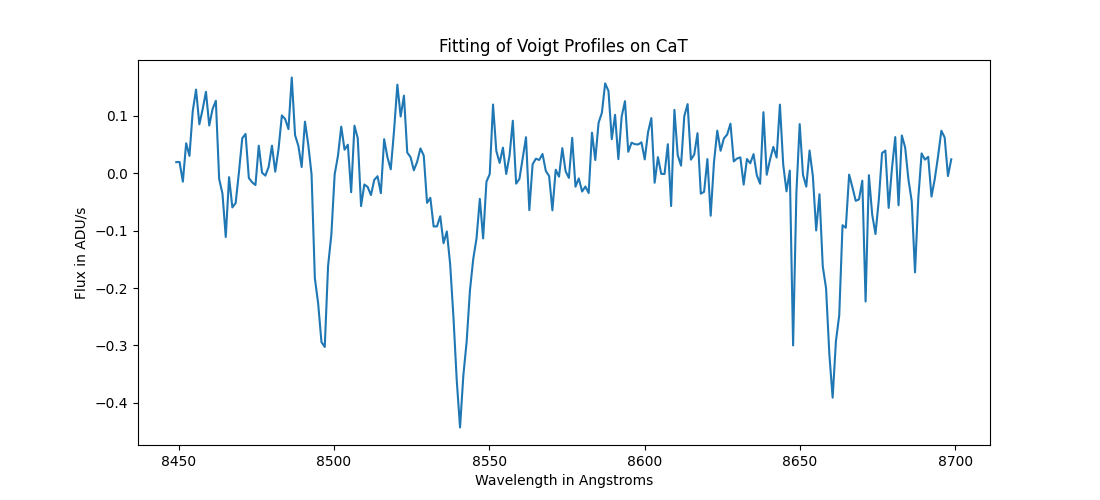

Mean: [8660.447864201316]
Endpoints: [8650.037101043075]
Endpoints: [8650.037101043075, 8670.317861621854]
Amplitude:-0.39078570857085015
Model: Voigt1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           x_0            amplitude_L           fwhm_L            fwhm_G      
    ----------------- ------------------- ----------------- ------------------
    8660.523965815135 -0.6077689013045865 2.477849918356714 3.4025522505802757
voigt curve plotted


In [31]:
%matplotlib widget
# Inputting the new spectrum into the Gaussian/Voigt fitting function.
# When you fit a line, please record the wavelength and repeat the process
# for the other 2 lines. Please use zoom provided to ensure the best fit
# and to estimate the observed wavelengths more precisely.
# Please don't pay attention to "this fit might be unsuccessful" warning.
# We recommend fitting the central line 5 times and once each of the side lines.
# The standard deviation for the central line (that comes from human error)
# can be used to estimate uncertainty from click.
# Here, the Voigt fitting process is demonstrated for the central CaT.
# For the radial velocity calculation made for the central CaT,
# please use the wavelength that was observed more often or use the median
# if there were no repetitive observations.
voigtres, xvoigt = pipe.modelling_widget(calcium_spec_comb, model = 'voigt')

# Radial velocity calculations

In [26]:
# These are the rest wavelengths.
# They can be found here: https://www.aanda.org/articles/aa/pdf/2015/08/aa26534-15.pdf
rest_l = 8498.02
rest_c = 8542.09
rest_r = 8662.14

The observed wavelengths should be found in the "Voigt curve fitting" section.

In [28]:
# Calculating radial velocity for central CaT line.
cr = pipe.doppler_shift(rest = rest_c, obs = 8540.77)
print(cr)

-46.33018618628771 km / s


In [30]:
# Calculating radial velocity for left CaT line.
l = pipe.doppler_shift(rest = rest_l, obs = 8496.15)
print(l)

-65.97696617983475 km / s


In [32]:
# Calculating radial velocity for right CaT line.
r = pipe.doppler_shift(rest = rest_r, obs = 8660.45)
print(r)

-58.495784890977276 km / s


In [33]:
# Calculating average radial velocity for CaT.
avg = np.mean([cr / cr.unit, l / l.unit, r / r.unit]) * u.km/u.s
print(avg)

-56.934312419033255 km / s


# Calculating the uncertainty from click (see comments in "Voigt curve fitting" section above)

In [34]:
# Add the standard deviation to the observed wavelength to calculate
# the uncertainty coming from human error. Standard deviation can simply
# be calculated in the spreadsheet for the central CaT observed wavelengths.
# The difference when adding or subtracting the standard deviation to the
# observed wavelength used in the radial velocity calculation
# is negligible, so either can be employed.
cr_unc = pipe.doppler_shift(rest = rest_c, obs = 8540.77+0.001870828693)
print(abs(cr-cr_unc))

0.06566858230537065 km / s


# Calculating standard deviations of radial velocities computed from CaT lines from their average.

In [35]:
cr_dev = np.std([cr / cr.unit, avg / avg.unit])
print(cr_dev)

5.302063116372771


In [36]:
l_dev = np.std([l / l.unit, avg / avg.unit])
print(l_dev)

4.521326880400746


In [37]:
r_dev = np.std([r / r.unit, avg / avg.unit])
print(r_dev)

0.7807362359720109
